In [1]:
import time
import memory_profiler as mem_profile

import os

import numpy as np
from matplotlib import pyplot as plt
import cv2

import test
import mask
import roi
import utils

FULL_IMG_NAME = 'img_29.jpg'

# Diretórios da imagem original, arquivos temp. e restauração final
IMG_DIR_PATH = './images/'
INTERM_DIR_PATH = './interm_files/'
INPAINT_DIR_PATH = './inpaints/'

# Verifica se existem os diretórios e cria os que não existem
if not os.path.exists(INTERM_DIR_PATH):
    os.mkdir(INTERM_DIR_PATH)
if not os.path.exists(INPAINT_DIR_PATH):
    os.mkdir(INPAINT_DIR_PATH)

# Define os caminhos para as imagens
IMG_EXTENSION = FULL_IMG_NAME[-4:]
IMG_NAME = FULL_IMG_NAME[:-4]
IMG_FILEPATH = IMG_DIR_PATH + FULL_IMG_NAME
CROP_FILEPATH = INTERM_DIR_PATH + IMG_NAME + '_crop' + IMG_EXTENSION
FACE_FILEPATH = INTERM_DIR_PATH + IMG_NAME + '_face' + IMG_EXTENSION
MASK_FACE_FILEPATH = INTERM_DIR_PATH + IMG_NAME + '_face_mask' + IMG_EXTENSION
MASK_IMG_FILEPATH = INTERM_DIR_PATH + IMG_NAME + '_img_mask' + IMG_EXTENSION
INPAINT_FACE_FILEPATH = INTERM_DIR_PATH + IMG_NAME + '_face_inpaint' + IMG_EXTENSION
INPAINT_BACKGROUND_NS = INPAINT_DIR_PATH + IMG_NAME + '_inpaint_back_ns' + IMG_EXTENSION
INPAINT_BACKGROUND_FMM = INPAINT_DIR_PATH + IMG_NAME + '_inpaint_back_fmm' + IMG_EXTENSION
INPAINT_FINAL_FILEPATH = INPAINT_DIR_PATH + IMG_NAME + '_inpaint' + IMG_EXTENSION
CHECKPOINT_DIR_PATH = './model_logs/release_celeba_256/'

def val_img(IMG_FILEPATH, IMG_EXTENSION):
    print('Validando a imagem de entrada...')
    image = utils.validate_input_image(IMG_FILEPATH, IMG_EXTENSION)
    print(image.shape)
    utils.print_done()
    # plt.imshow(image)
    return image

def identify_img(image):
    print('Identificando o rosto na imagem...')
    try:
        # Identificação do rosto
        x, y, w, h = roi.identify_face(image)[0]
    except:
        x = 0
        y = 0
        h, w, p = image.shape

        if w != h:
            min_size = min(w,h)
            if w == min_size:
                y = int(y + (h-w)/2)
                h = w
            elif h == min_size:
                x = int(x + (w-h)/2)
                w = h
    # image_copy = np.copy(image)
    # cv2.rectangle(image_copy, (x,y), (x+w,y+h), (255,0,0), 10)
    # plt.imshow(image_copy)
    # Corte do rosto
    image_cropped = image[y:y+h, x:x+w]
    #     cv2.imwrite(CROP_FILEPATH, cv2.cvtColor(image_cropped, cv2.COLOR_BGR2RGB))
    #     plt.imshow(image_cropped)
    # Redimensionamento do rosto
    face = utils.resize_face(w, h, image_cropped)
    cv2.imwrite(FACE_FILEPATH, cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
    # plt.imshow(face)
    utils.print_done()
    return face, x, y, w, h

def identify_eyes(face):
    print('Identificando os olhos...')
    true_eyes = roi.detect_eyes(face)
    # face_copy = np.copy(face)
    # for (ex, ey, ew, eh) in true_eyes:
    #     cv2.ellipse(face_copy,(int(ex+0.5*ew), int(ey+0.5*eh)),(int(ew/2),int(eh/4)),0,0,360,(0, 255, 0),2)
    # plt.imshow(face_copy)
    utils.print_done()
    return true_eyes

def create_face_mask(face, true_eyes):
    print('Criando a máscara para o rosto...')
    face_rect_mask = mask.get_rect_mask(face)
    face_mask = mask.get_mask(face)
    mask.remove_eyes_from_mask(face_mask, true_eyes)
    mixed = ~face_rect_mask & face_mask
    mask.remove_eyes_from_mask(face_rect_mask, true_eyes)
    mask.remove_border_from_mask(face_rect_mask)
    cv2.imwrite(MASK_FACE_FILEPATH, face_rect_mask)
    # plt.imshow(face_rect_mask, cmap='gray')
    utils.print_done()
    return face_rect_mask, mixed

def rest_generative(FACE_FILEPATH, MASK_FACE_FILEPATH, INPAINT_FACE_FILEPATH, 
                    CHECKPOINT_DIR_PATH, face, mixed, w, h):
    print('Restaurando o rosto com Generative Inpaint...')
    face_inpaint = test.run_inpaint(image = FACE_FILEPATH,
                                     mask = MASK_FACE_FILEPATH,
                                     output = INPAINT_FACE_FILEPATH,
                                     checkpoint_dir = CHECKPOINT_DIR_PATH)
    face_inpaint2 = cv2.inpaint(face, mixed, 3, cv2.INPAINT_TELEA)
    face_inpaint[mixed==255] = face_inpaint2[mixed==255]
    # cv2.imwrite(INPAINT_FACE_FILEPATH, cv2.cvtColor(face_inpaint, cv2.COLOR_BGR2RGB))
    # plt.imshow(face_inpaint)
    # Redimensionando o rosto restaurado para o tamanho original
    face_inpaint_redim = cv2.resize(face_inpaint, (w, h), interpolation = cv2.INTER_AREA)
    utils.print_done()
    return face_inpaint_redim
    
def create_background_mask(image):
    print('Cria a máscara do fundo da imagem...')
    image_mask = mask.get_mask(image)
    # cv2.imwrite(MASK_IMG_FILEPATH, image_mask)
    # plt.imshow(image_mask, cmap='gray')
    mask.remove_face_from_mask(image_mask, x, y, w, h)
    return image_mask
    
def rest_opencv_fmm(image, image_mask):
    print('Restaurando o fundo da imagem com Fast Marching...')
    image_inpaint_fmm = cv2.inpaint(image, image_mask, 3, cv2.INPAINT_TELEA)
    cv2.imwrite(INPAINT_BACKGROUND_FMM, cv2.cvtColor(image_inpaint_fmm, cv2.COLOR_BGR2RGB))
    # plt.imshow(image_inpaint)
    utils.print_done()
    return image_inpaint_fmm

def rest_opencv_ns(image, image_mask):
    print('Restaurando o fundo da imagem com Navier-Stokes...')
    image_inpaint_ns = cv2.inpaint(image, image_mask, 3, cv2.INPAINT_NS)
    cv2.imwrite(INPAINT_BACKGROUND_NS, cv2.cvtColor(image_inpaint_ns, cv2.COLOR_BGR2RGB))
    # plt.imshow(image_inpaint)
    utils.print_done()
    return image_inpaint_ns

def rest_union(image_inpaint, face_inpaint_redim, x, y):
    print('Reconstruindo a imagem completa...')
    image_final = np.copy(image_inpaint)
    image_final[y:y+h, x:x+w] = face_inpaint_redim
    cv2.imwrite(INPAINT_FINAL_FILEPATH, cv2.cvtColor(image_final, cv2.COLOR_BGR2RGB))
    # plt.imshow(image_final)
    utils.print_done()
    return image_final

/home/izabel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
[2018-11-13 15:06:58 @__init__.py:79] Set root logger. Unset logger with neuralgym.unset_logger().
[2018-11-13 15:06:58 @__init__.py:80] Saving logging to file: neuralgym_logs/20181113150658654573.


In [2]:
def print_time_and_memory(t1, t2):
    print ('Tempo gasto: ' + str(round(t2-t1, 2)) + ' seg')
    print('Memória utilizada: ' + str(mem_profile.memory_usage()) + ' Mb \n')

In [3]:
ti = time.clock()

# Validação da imagem de entrada
tp = time.clock()
image = val_img(IMG_FILEPATH, IMG_EXTENSION)
tf = time.clock()
print_time_and_memory(tp, tf)

# Identiicação do rosto
tp = time.clock()
face, x, y, w, h = identify_img(image)
tf = time.clock()
print_time_and_memory(tp, tf)

# Identificação dos olhos
tp = time.clock()
true_eyes = identify_eyes(face)
tf = time.clock()
print_time_and_memory(tp, tf)

# Criação da máscara do rosto
tp = time.clock()
face_rect_mask, mixed = create_face_mask(face, true_eyes)
tf = time.clock()
print_time_and_memory(tp, tf)

# Restauração generativa
tp = time.clock()
face_inpaint_redim = rest_generative(FACE_FILEPATH, MASK_FACE_FILEPATH, INPAINT_FACE_FILEPATH, 
                                     CHECKPOINT_DIR_PATH, face, mixed, w, h)
tf = time.clock()
print_time_and_memory(tp, tf)

# Criação da máscara da imagem
tp = time.clock()
image_mask = create_background_mask(image)
tf = time.clock()
print_time_and_memory(tp, tf)

# Restauração do fundo da imagem com NS
tp = time.clock()
image_inpaint_ns = rest_opencv_ns(image, image_mask)
tf = time.clock()
print_time_and_memory(tp, tf)

# Restauração do fundo da imagem com FMM
tp = time.clock()
image_inpaint_fmm = rest_opencv_fmm(image, image_mask)
tf = time.clock()
print_time_and_memory(tp, tf)

image_inpaint = image_inpaint_ns

# União do rosto e fundo restaurados
tp = time.clock()
image_final = rest_union(image_inpaint, face_inpaint_redim, x, y)
tf = time.clock()
print_time_and_memory(tp, tf)

print('Execução do programa completo')
print_time_and_memory(ti, tf)

Validando a imagem de entrada...
(3156, 2691, 3)
Pronto.
Tempo gasto: 0.19 seg
Memória utilizada: [321.9375] Mb 

Identificando o rosto na imagem...
Pronto.
Tempo gasto: 69.63 seg
Memória utilizada: [1226.37109375] Mb 

Identificando os olhos...
Pronto.
Tempo gasto: 0.2 seg
Memória utilizada: [1226.37109375] Mb 

Criando a máscara para o rosto...
Pronto.
Tempo gasto: 0.09 seg
Memória utilizada: [1227.66015625] Mb 

Restaurando o rosto com Generative Inpaint...
Pronto.
Tempo gasto: 6.76 seg
Memória utilizada: [1373.6484375] Mb 

Cria a máscara do fundo da imagem...
Tempo gasto: 9.04 seg
Memória utilizada: [1383.859375] Mb 

Restaurando o fundo da imagem com Navier-Stokes...
Pronto.
Tempo gasto: 95.59 seg
Memória utilizada: [1458.421875] Mb 

Restaurando o fundo da imagem com Fast Marching...
Pronto.
Tempo gasto: 145.45 seg
Memória utilizada: [1456.43359375] Mb 

Reconstruindo a imagem completa...
Pronto.
Tempo gasto: 0.3 seg
Memória utilizada: [1483.29296875] Mb 

Execução do programa c

Restauração com NS


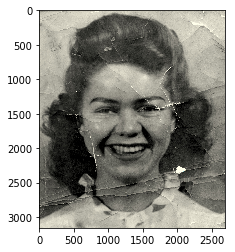

In [4]:
print('Restauração com NS')
plt.imshow(image_inpaint_ns)

Restauração com FMM


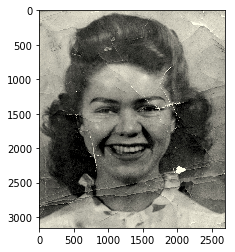

In [5]:
print('Restauração com FMM')
plt.imshow(image_inpaint_fmm)